<a href="https://colab.research.google.com/github/jaya-shankar/education-impact/blob/master/life_expectancy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model Performace History

1.   Cosidering life expectancy as input
      
      1. *Training using max no of countries:*\
          **MSE**: 1.421960711479187
          
      2. *Training using min no of countries:*\
          **MSE**: 1.6800711154937744

      3. *Training using only common countries:*\
          **MSE**: 1.5712116956710815

2.   Not cosidering life expectancy as input
      1. *Trained using max no of countries:*\
          **MSE**: 1.9395439624786377

      2. *Trained using min no of countries*:\
          **MSE**: 2.161480665206909

      3. *Trained using only common countries*:\
          **MSE**: 2.10016131401062



In [1]:
!rm -rf education-impact
!rm education-impact

rm: cannot remove 'education-impact': No such file or directory


In [1]:
!git clone https://github.com/jaya-shankar/education-impact.git


Cloning into 'education-impact'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 282 (delta 137), reused 132 (delta 38), pack-reused 0
Receiving objects: 100% (282/282), 1.84 MiB | 7.12 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [2]:
!pip install tensorflow_decision_forests
!pip install wurlitzer
!pip install seaborn

     |████████████████████████████████| 17.1 MB 323 kB/s 


In [3]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from wurlitzer import sys_pipes

In [4]:
#@title Default title text
root = "education-impact/" 
datasets_path = {
                    "infant_mortality"              :  root+ "datasets/Infant_Mortality_Rate.csv",
                    "child_mortality"               :  root+ "datasets/child_mortality_0_5_year_olds_dying_per_1000_born.csv",
                    "children_per_woman"            :  root+ "datasets/children_per_woman_total_fertility.csv",
                    "co2_emissions"                 :  root+"datasets/co2_emissions_tonnes_per_person.csv",
                    "population"                    :  root+ "datasets/converted_pop.csv",
                    "food_supply"                   :  root+ "datasets/food_supply_kilocalories_per_person_and_day.csv",
                    "gdp_per_captia"                :  root+ "datasets/gdp_per_capita_yearly_growth.csv",
                    "Avg_daily_income_ppp"          :  root+ "datasets/mincpcap_cppp.csv",
                    "gini_index"                    :  root+ "datasets/gini.csv",
                    "life_expectancy"               :  root+ "datasets/life_expectancy_years.csv",
                    "malnutrition"                  :  root+ "datasets/malnutrition_weight_for_age_percent_of_children_under_5.csv",
                    "poverty_index"                 :  root+ "datasets/mincpcap_cppp.csv",
                    "maternal_mortality"            :  root+ "datasets/mmr_who.csv",
                    "people_in_poverty"             :  root+ "datasets/number_of_people_in_poverty.csv",
                    "primary_completion"            :  root+ "datasets/primary_school_completion_percent_of_girls.csv",
                    "ratio_b/g_in_primary"          :  root+ "datasets/ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv",
                    "wcde-25--34"                   :  root+ "datasets/wcde-25--34.csv",
                    "wcde-Incomplete_Primary"       :  root+ "datasets/wcde-Incomplete Primary.csv",
                    "wcde-Lower_Secondary"          :  root+ "datasets/wcde-Lower Secondary.csv",
                    "wcde-Post_Secondary"           :  root+ "datasets/wcde-Post Secondary.csv",
                    "wcde_female-Incomplete_Primary":  root+ "datasets/wcde_female-Incomplete Primary.csv",
                    "wcde_female-Lower_Secondary"   :  root+ "datasets/wcde_female-Lower Secondary.csv",
                    "wcde_female-Post_Secondary"    :  root+ "datasets/wcde_female-Post Secondary.csv",
                }

In [8]:
datasets = [
            "infant_mortality",
            "life_expectancy",
            "child_mortality",
            "co2_emissions",
            "Avg_daily_income_ppp",
            "wcde-Incomplete_Primary",
            "wcde-Lower_Secondary",
            "population",
            "wcde_female-Lower_Secondary"
            ]

In [9]:
PREDICT_FUTURE  = 10
OUTPUTS         = ['life_expectancy']
                   

In [10]:
# to find out how many countries each dataset has
countries_count      = None
least_dataset_path   = None
for dataset in datasets:
  df = pd.read_csv(datasets_path[dataset])
  count = len(set(df.Country.unique()))
  if not countries_count:
    countries_count = count
    least_dataset_path   = datasets_path[dataset]
  elif countries_count > count:
    countries_count = count
    least_dataset_path   = datasets_path[dataset]
  print(f"{'Factor: ' + dataset:<30} count: {count}")
print(f"{'To use: ' + least_dataset_path:<30} count: {countries_count}")

Factor: infant_mortality       count: 266
Factor: life_expectancy        count: 195
Factor: child_mortality        count: 197
Factor: co2_emissions          count: 194
Factor: Avg_daily_income_ppp   count: 195
Factor: wcde-Incomplete_Primary count: 202
Factor: wcde-Lower_Secondary   count: 202
Factor: population             count: 197
Factor: wcde_female-Lower_Secondary count: 202
To use: education-impact/datasets/co2_emissions_tonnes_per_person.csv count: 194


In [11]:
common_countries = set()
for dataset in datasets:
  countries_list = list(pd.read_csv(datasets_path[dataset]).Country)
  countries_list = set(map(lambda x: x.lower(), countries_list))
  if common_countries == set():
    common_countries = countries_list
  else:
    common_countries = common_countries.intersection(countries_list)
len(common_countries)

154

In [12]:
# creating a list of all countries & years
countries = list(common_countries)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]

In [13]:
len(countries)

154

In [14]:
keys=[]
for y in years:
  for c in countries:
    keys.append((c,str(y)))

In [15]:
big_dic = {k : [] for k in keys}
for dataset in datasets:
  df = pd.read_csv(datasets_path[dataset])
  df["Country"] = df["Country"].str.lower()
  df.set_index("Country", inplace=True)
  for k in keys:
    try:
      big_dic[k].append(df.loc[k[0]][k[1]])
    except:
      big_dic[k].append(np.NaN)
 

In [16]:
for output_path in OUTPUTS:
  df = pd.read_csv(datasets_path[output_path])
  df["Country"] = df["Country"].str.lower()
  df.set_index("Country", inplace=True)
  for k in keys:
    try:
      big_dic[k].append(df.loc[k[0]][str(int(k[1])+PREDICT_FUTURE)])
    except:
      big_dic[k].append(np.NaN)

In [17]:
columns = [k for k in datasets ]
output_columns = ["o_"+o for o in OUTPUTS]
columns.extend(output_columns)

In [18]:
input_df = pd.DataFrame.from_dict(big_dic,orient='index', columns = columns)
output_df = input_df[["o_"+o for o in OUTPUTS]]
input_df.drop(labels=["o_"+o for o in OUTPUTS], axis = 1, inplace=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

In [20]:
X_train.isna().sum()

infant_mortality               537
life_expectancy                  0
child_mortality                  0
co2_emissions                  123
Avg_daily_income_ppp             0
wcde-Incomplete_Primary          0
wcde-Lower_Secondary             0
population                       0
wcde_female-Lower_Secondary      0
dtype: int64

In [21]:
y_train.isna().sum()

o_life_expectancy    0
dtype: int64

In [23]:
X_train

,infant_mortality,life_expectancy,child_mortality,co2_emissions,Avg_daily_income_ppp,wcde-Incomplete_Primary,wcde-Lower_Secondary,population,wcde_female-Lower_Secondary
"(samoa, 1999)",18.3,68.3,21.9,0.7820,8.03,1.50,76.48,174000,74.78
"(angola, 1980)",140.2,48.1,238.0,0.6400,5.78,76.60,23.10,8340000,7.50
"(guyana, 1999)",37.7,64.1,47.8,2.2400,7.85,3.92,58.88,750000,58.02
"(estonia, 1963)",NaN,70.0,35.6,9.6600,8.27,0.24,53.98,1260000,52.06
"(uzbekistan, 1966)",NaN,63.4,153.0,5.8100,4.20,0.00,0.00,10500000,0.00
...,...,...,...,...,...,...,...,...,...
"(morocco, 2000)",41.7,69.5,49.4,1.1700,6.66,51.60,36.50,28800000,29.50
"(sierra leone, 1975)",177.2,47.4,308.0,0.1730,1.82,82.60,15.30,3040000,8.80
"(saudi arabia, 1974)",97.7,63.1,140.0,14.0000,24.80,59.14,31.74,7050000,17.10
"(uganda, 1982)",126.0,51.0,210.0,0.0413,2.39,66.60,31.16,13200000,22.58


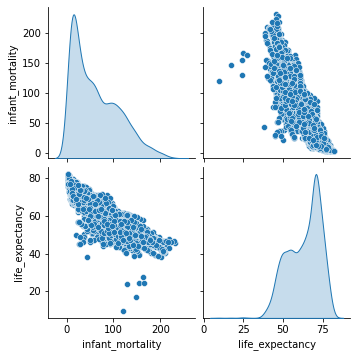

In [31]:
sns.pairplot(X_train[["infant_mortality","life_expectancy"]], diag_kind="kde")

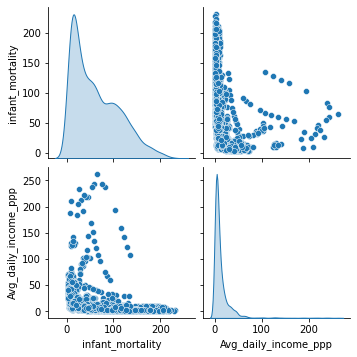

In [32]:
sns.pairplot(X_train[["infant_mortality","Avg_daily_income_ppp"]], diag_kind="kde")

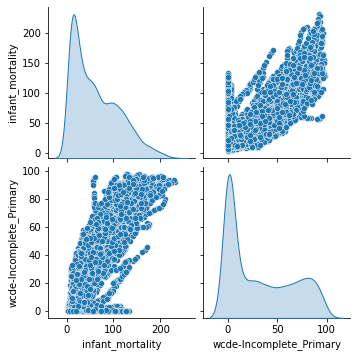

In [34]:
sns.pairplot(X_train[["infant_mortality","wcde-Incomplete_Primary"]], diag_kind="kde")

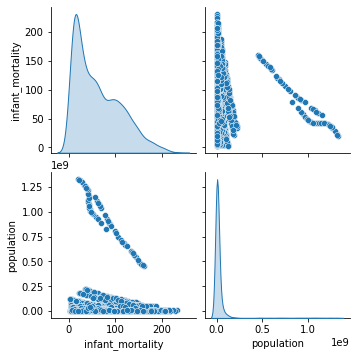

In [35]:
sns.pairplot(X_train[["infant_mortality","population"]], diag_kind="kde")

In [76]:
y_train

,o_life_expectancy
"(ida & ibrd total, 1992)",NaN
"(northern mariana islands, 2003)",NaN
"(burkina faso, 2004)",59.4
"(peru, 1984)",71.2
"(palau, 1999)",67.0
...,...
"(russian federation, 1967)",NaN
"(lithuania, 1999)",73.0
"(albania, 1990)",75.4
"(nicaragua, 1968)",63.1


In [77]:
combine_dfs("o_"+OUTPUTS[0],X_test,y_test)

,infant_mortality,life_expectancy,child_mortality,co2_emissions,Avg_daily_income_ppp,wcde-Incomplete_Primary,wcde-Lower_Secondary,population,wcde_female-Lower_Secondary,o_life_expectancy
"(israel, 1999)",5.8,78.7,7.17,9.4100,25.90,3.66,38.62,5820000.0,32.08,81.4
"(slovak republic, 2004)",7.1,74.6,8.50,7.9500,13.70,NaN,NaN,5400000.0,NaN,76.9
"(dominica, 1987)",13.6,71.4,16.00,0.6640,6.82,NaN,NaN,71800.0,NaN,72.1
"(marshall islands, 1978)",51.1,62.3,67.10,NaN,4.79,NaN,NaN,28400.0,NaN,63.3
"(mongolia, 1964)",NaN,46.7,216.00,1.9000,2.87,9.84,57.94,1070000.0,62.14,54.9
...,...,...,...,...,...,...,...,...,...,...
"(cambodia, 1987)",85.1,56.5,117.00,0.0532,1.90,68.56,29.66,8199999.0,21.72,59.4
"(andorra, 1973)",NaN,77.4,22.20,NaN,43.20,NaN,NaN,28200.0,NaN,78.5
"(angola, 1991)",131.2,50.3,224.00,0.4140,4.96,64.16,34.88,12200000.0,18.26,53.4
"(qatar, 1970)",50.2,67.0,65.50,69.1000,102.00,48.50,32.70,110000.0,29.40,70.3


In [78]:
def combine_dfs(label,X,y):
  frames      = [X,y[label]]
  le_model_df = pd.concat(frames,axis=1)
  le_model_df.dropna(subset=[label],inplace=True)
  return le_model_df

In [131]:
for output in OUTPUTS:
  # converting pandas to tensorFlow dataset
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs("o_"+output,X_train,y_train), label="o_"+output, task=tfdf.keras.Task.REGRESSION)
  model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
  
  model.fit(x=train_ds)
  # Convert it to a TensorFlow dataset
  test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs("o_"+output,X_train,y_train), label="o_"+output, task=tfdf.keras.Task.REGRESSION)

  # Evaluate the model
  model.compile(metrics=["mse"])
  # Evaluate the model on the test dataset.
  evaluation = model.evaluate(test_ds, return_dict=True)
  print(output.upper())
  print(evaluation)
  print()
  print(f"MSE: {evaluation['mse']}")
  print(f"RMSE: {math.sqrt(evaluation['mse'])}")
  print()

78/78 [==============================] - 5s 68ms/step


78/78 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - mse: 2.1002
LIFE_EXPECTANCY
{'loss': 0.0, 'mse': 2.10016131401062}

MSE: 2.10016131401062
RMSE: 1.4491933321715982



In [132]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# %set_cell_height 300

model.summary()

# CNN Algorithm

from the above output
- **malnutrition & people in povery** have least no of countries
- **infant mortality & gdp per captia** have highest no of countries

*Doubt:* Does having more data for one factor will make the decision tree bias?


###Steps
1. create a csv file such that each row contains all values of particular year & country present
2. the output for each row is year + 40 years corresponding value 
    1. **outputs** - life expectany, education level, gdp




From above output
- if we dont drop any rows our table size = 4256 entries
- if we drop rows containing any if all of outputs missing then our table size = 3039 entries
- if we drop rows containing any one of output missing then our table size = 1745 entries

so, I think its is better to go with second choice and build different models, but not sure it will not effect performance of the model


now we have the dataframe containing both inputs and ouputs,our next step is
1. split the data into train & test data
  1. try to split data based on continents to reduce bias
2. build DF model using tensorflow
3. check the accuracy of the model